## SEMINARSKA NALOGA

### PRIDOBITEV IN OBLIKOVANJE PODATKOV
 
Stolpci, ki opisujejo naše podatke so naslednji:  
* ZaporednaStevilkaKD,
* MesecStoritve,
* UraStoritve,
* DanVTednu,
* OrganizacijskaEnotaStoritve,
* Povratnik,
* OpisKD,
* PoglavjeKD,
* GospodarskiKriminal,
* OrganiziranKriminal,
* MladoletniskaKriminaliteta,
* Poskus,
* KriminalisticnaOznacba1,
* KriminalisticnaOznacba2,
* KriminalisticnaOznacba3,
* UporabljenoSredstvo1,
* UporabljenoSredstvo2,
* UporabljenoSredstvo3,
* UporabljenoSredstvo4,
* UpravnaEnota,
* OpisKraja,
* LetoZakljucnegaDokumenta,
* VrstaZakDokumenta,
* ZaporednaStevilkaOsebeVKD,
* VrstaOsebe,
* StarostniRazred,
* Spol,
* Drzavljanstvo,
* Poskodba,
* VplivAlkohola,
* VplivMamil,
* OrganiziranaZdruzba,
* Skoda    

Za pridobitev podatkov smo uporabili Pythonovo knjižnico Pandas, saj je z le to enostavno delati. Najprej smo prebrali podatke iz vsake .csv datoteke posebej (za Windows in Mac operacijske sisteme smo uporabili drugačen delilec poti do datotek), ter jih shranili v slovar, kot ključ: ime datoteke, vrednost: pandas dataframe te datoteke.

In [23]:
import pandas as pd
import glob
import warnings
import platform
from copy import copy
warnings.filterwarnings('ignore')

if (platform.system() == 'Windows'):
    l = glob.glob('data/*.csv')
    for i in range(len(l)):
        l[i] = l[i].split('\\')[-1].upper()

    # slovar poti do .csv datotek 
    csv_data = {data.split('\\')[1].split('.')[0].upper():data for data in glob.glob('data/*.csv')}
    
    # MAC IN LINUX IMATA DRUGACNE OZNAKE
else:
    l = glob.glob('data/*.csv')
    for i in range(len(l)):
        l[i] = l[i].split('/')[-1].upper()

    # slovar poti do .csv datotek 
    csv_data = {data.split('/')[1].split('.')[0].upper():data for data in glob.glob('data/*.csv')}

In [24]:
dataframes = {}
for key, value in csv_data.items():
    df = pd.read_csv(csv_data[key], sep=';', encoding='cp1250', skipinitialspace = True)
    dataframes[key.upper()] = df

for df1 in dataframes.values():
    df1.columns = ['MesecStoritve' if x == 'DatumStoritve' else x for x in df]

Iz ustvarjenega seznama smo nato združili vse podatke v dataframe vseh podatkov, da ne bi prišlo do zmede med letnico napisano na dokumentu in dejansko letnico kadar je bilo kaznivo dejanje storjeno. V ta namen smo naredili dataframe full_KD, v katerega smo dodali stolpec MesecStoritve ter LetoStoritve.

In [25]:
dataframes_copy = copy(dataframes)
frames = [copy(dataframes_copy['KD2009'])]
for i in range(10, 21):
    frames.append(copy(dataframes_copy['KD20'+str(i)]))

all_data = pd.concat(frames)
all_data

# tu se naredi preslikava glede iz neberljive oblike datuma v berljivo obliko
mesci = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']
mesci2 = []
leta = []

# this dataframe is the one used for the analysis
full_KD = all_data

for i in full_KD['MesecStoritve']:
    mesec = str(i)[:-4]
    leto = str(i)[-4:]

    leta.append(leto)
    mesci2.append(mesci[int(mesec) - 1])


full_KD.rename(columns={'MesecStoritve': 'CasovnaOznaka'}, inplace=True)
full_KD['MesecStoritve'] = mesci2
full_KD['LetoStoritve'] = leta
full_KD['LetoStoritve'] = full_KD['LetoStoritve'].astype(int)

Da bi bili grafi bolj usklajeni med seboj smo uporabili naslednjo barvno paleto:

In [26]:
color_pallete = ['#FF0170', '#F72585', '#B5179E', '#7209B7', '#560BAD', '#480CA8', '#3A0CA3', '#3F37C9', '#4361EE', '#4895EF', '#4CC9F0', '#82D8F2']

**Število kaznivih dejanj v Sloveniji po občinah in po regijah**

Zanimalo nas je kako se med seboj po kaznivih dejanjih med seboj razlikujejo posamezne občine Slovenije. V drugem grafu pa smo prikazali kako se med seboj razlikujejo posamezne regije po kaznivih dejanjih.    
Za karseda berljiv prikaz smo uporabili knjižnico Geopandas, ki omogoča prikaz zemljevida in ga obarva glede na stolpec v katerem so števila, ki jih želimo prikazati. Uporabili smo .shp datoteke Slovenije in sicer v mapi "slovenija_map/obcine/obc.shp" za občine Slovenije in "slovenija_map/regije/reg.shp" za Slovenske regije.

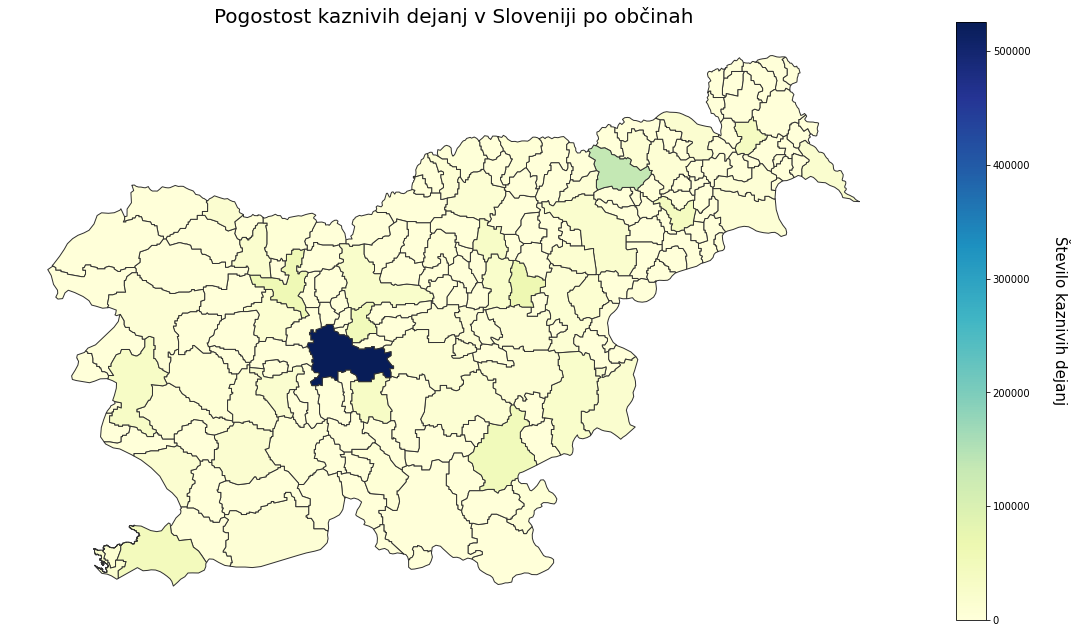

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

obcine = dict(full_KD.UpravnaEnotaStoritve.value_counts())
obcine_popravljene = {}
odstrani = ['NEZNANA OBČ', 'NEZNANA UE', 'NI PODATKA']
for o in odstrani:
    if o in obcine.keys():
        obcine.pop(o)

for key, value in obcine.items():
    crke = ['Č', 'Š', 'Ž']
    k = key
    for i in 'ČŠŽ':
        k = k.replace(i, '?')
    obcine_popravljene[k] = value
obcine_popravljene

obcine_popravljene['LJUBLJANA'] = obcine_popravljene['LJUBLJANA']

slovenia = gpd.read_file('slovenija_map/obcine/obc.shp', encoding='cp1250')
slovenia['name_2'] = slovenia['name_2'].str.upper()

list_of_all = list(slovenia.name_2)
list_stevio = []

for i in list_of_all:
    if i in obcine_popravljene.keys():
        list_stevio.append(obcine_popravljene[i])
    else:
        list_stevio.append(0)

slovenia['stevilo'] = list_stevio
fig, ax = plt.subplots(1, figsize=(20, 20))
plt.axis('off')
plt.title('Pogostost kaznivih dejanj v Sloveniji po občinah', fontsize=20)
slovenia.plot(column='stevilo', cmap='YlGnBu', ax=ax, edgecolor='.2')
bar_info = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=max(obcine.values())))
bar_info._A = []
cbar = fig.colorbar(bar_info, shrink=0.55)
cbar.set_label('Število kaznivih dejanj', fontsize=15, rotation=270, labelpad=40)

**Ugotovitve:**    
Iz zemljevida je kot po pričakovanjih razvidno da je največ kaznivih dejanj pripisanih Ljubljani(500.000 primerov), naslednja občina pa je občina Maribor(200.000 primerov). Ostale občine se gibljejo okoli 100.000 primerov kaznivih dejanj in manj. 

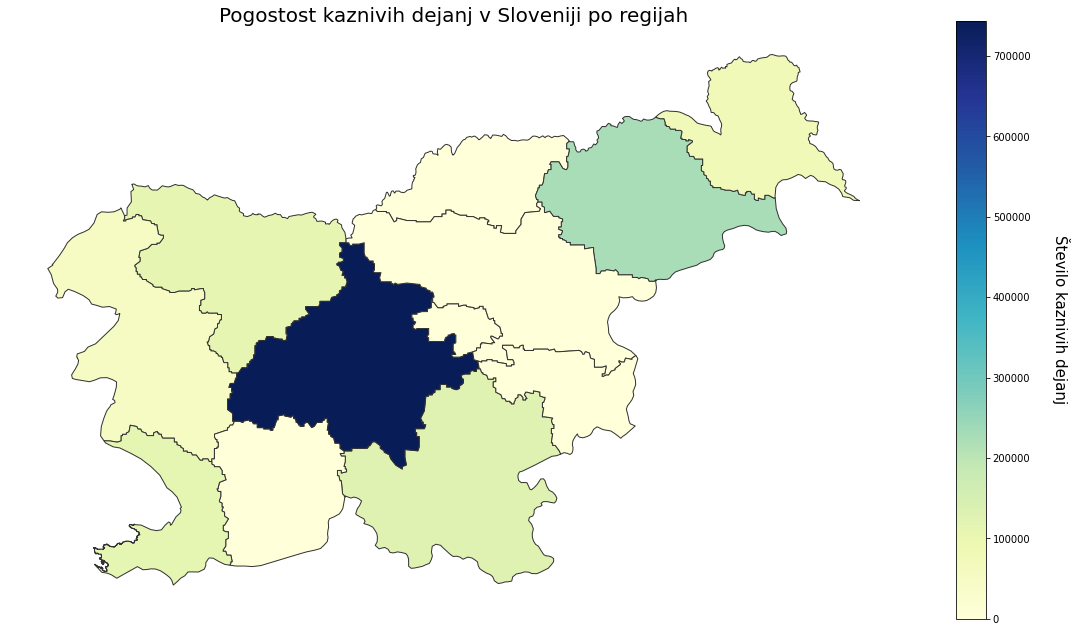

In [28]:
seznam_PU = full_KD.PUStoritveKD.value_counts()

stevilo = [seznam_PU["PU KRANJ"], seznam_PU["PU NOVA GORICA"], seznam_PU["PU NOVO MESTO"], 0, 0, seznam_PU["PU KOPER"], seznam_PU["PU LJUBLJANA"]+seznam_PU["GPU"]
            , 0, seznam_PU["PU MARIBOR"], 0, seznam_PU["PU MURSKA SOBOTA"], 0]


slovenia = gpd.read_file('slovenija_map/regije/reg.shp', encoding='cp1250')

slovenia['stevilo'] = stevilo
fig, ax = plt.subplots(1, figsize=(20, 20))
plt.axis('off')
plt.title('Pogostost kaznivih dejanj v Sloveniji po regijah', fontsize=20)
slovenia.plot(column='stevilo', cmap='YlGnBu', ax=ax, edgecolor='.2')
bar_info = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=max(stevilo)))
bar_info._A = []
cbar = fig.colorbar(bar_info, shrink=0.55)
cbar.set_label('Število kaznivih dejanj', fontsize=15, rotation=270, labelpad=40)

**UGOTOVITVE:** Iz grafa lahko opazimo, da ima največ kaznivih dejanj v Sloveniji, osrednjeslovenska regija (700.000+), naslednja po lestvici pa je podravska regija. Ostale regije pa se gibljejo okoli 100.000 kaznivih dejanj ali manj.

**Število storjenih kaznivih dejanj skozi leta**    
Naslednje nas je zanimalo kako se spreminja število primerov kaznivih dejanj skozi leta. Za prikaz smo uporabili barplot. Za stolpes smo uporabili stolpec 'LetoStoritve'.

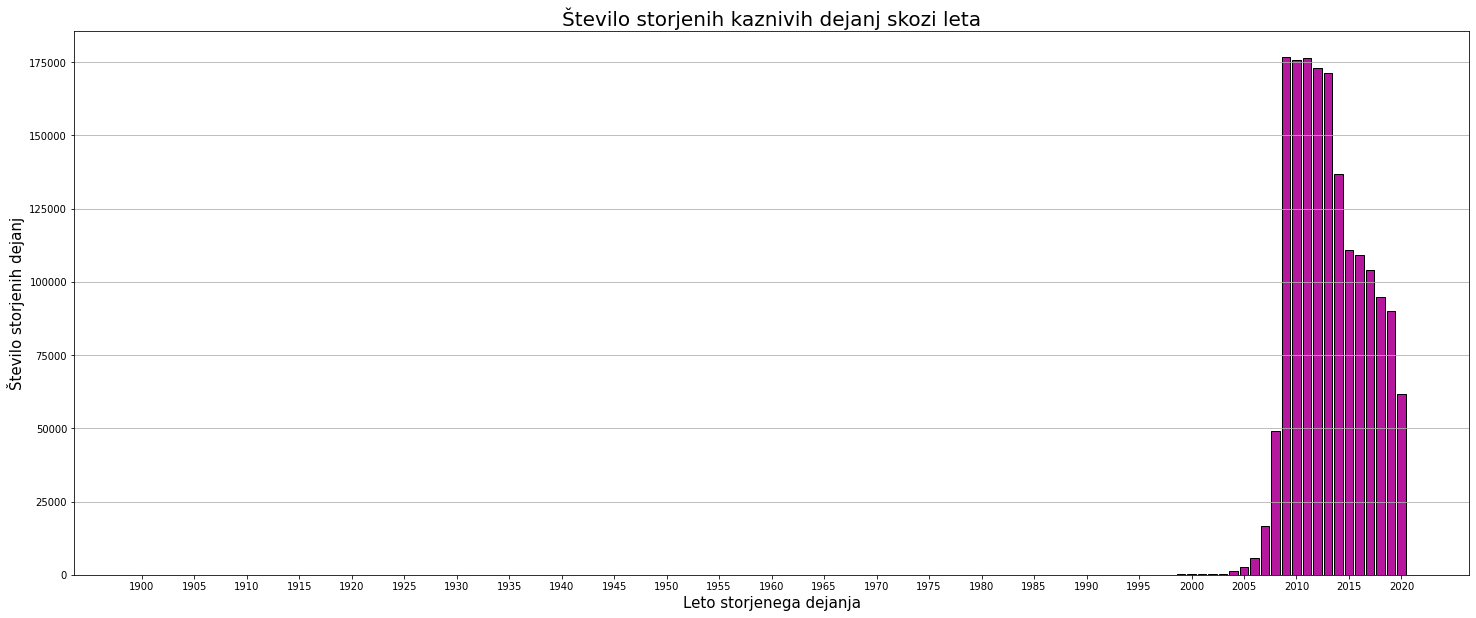

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

all_years = copy(all_data)
leta = all_years['LetoStoritve'].value_counts().sort_index()
x = list(leta.index)
y = list(leta)

plt.figure(figsize=(25,10))
plt.bar(x, y, color=color_pallete[2], edgecolor='black')
plt.grid(axis='y')
plt.title('Število storjenih kaznivih dejanj skozi leta', fontsize=20)
plt.xlabel('Leto storjenega dejanja', fontsize=15)
plt.ylabel('Število storjenih dejanj', fontsize=15)
plt.xticks(np.arange(x[0], x[-1]+5, step=5))
plt.show()

**Ugotovitve:**    
Iz grafa vidimo, da je do leta 2005 zabeleženih zelo malo primerov, saj imamo podatke v dokumentih zaključenih primerov. Kar pomeni da so potrebovali za primere starejše od leta 2005 zelo veliko časa. Iz grafa lahko razberemo da je največ primerov okoli leta 2010 in proti letu 2020 pada. Padec nam lahko pove da nekateri primeri iz teh let še niso bili zaključeni in da povprečnopotrebujejo okoli 5 let za zakjuček primera kaznivega dejanja.

**Razmerje med primeri, zaključenimi isto lete, ter primeri, ki niso bili zaključeni isto leto**    

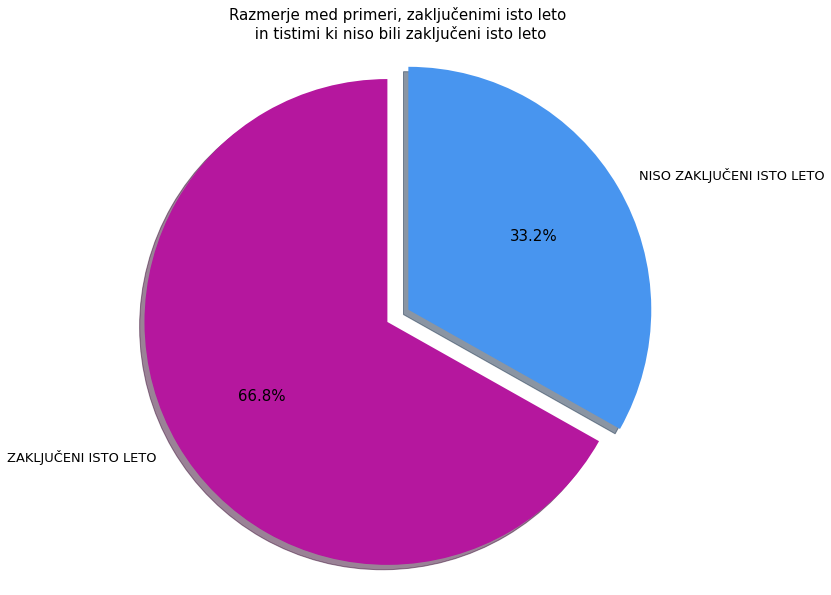

In [30]:
df_istoleto = copy(all_data)
df_not_istoleto = copy(all_data)
df_istoleto = df_istoleto[df_istoleto['LetoZakljucnegaDokumenta'] == df_istoleto['LetoStoritve']]
df_not_istoleto = df_not_istoleto[df_not_istoleto['LetoZakljucnegaDokumenta'] != df_not_istoleto['LetoStoritve']]
zalkjuceni_istoleto = len(df_istoleto)
ne_zalkjuceni_istoleto = len(df_not_istoleto)

x = ['ZAKLJUČENI ISTO LETO', 'NISO ZAKLJUČENI ISTO LETO']
y = [int(zalkjuceni_istoleto), int(ne_zalkjuceni_istoleto)]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(10,10)
patches, texts, autotexts = ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_pallete[2], color_pallete[9]])
ax1.axis('equal')
ax1.set_title('Razmerje med primeri, zaključenimi isto leto\n in tistimi ki niso bili zaključeni isto leto', fontsize=15)
for t in autotexts:
    t.set_fontsize(15)
for t in texts:
    t.set_fontsize(13)
plt.show()

**Ugotovitve:**    
Iz prikazanega grafa lahko vidimo, da sta  dve tretjini primerov zaključeni isto leto tretjina pa ne, kar nam lahko razloži padec v grafu iz prejšnjih ugotovitev.

**Število kaznivih dejanj po dnevih v tednu**


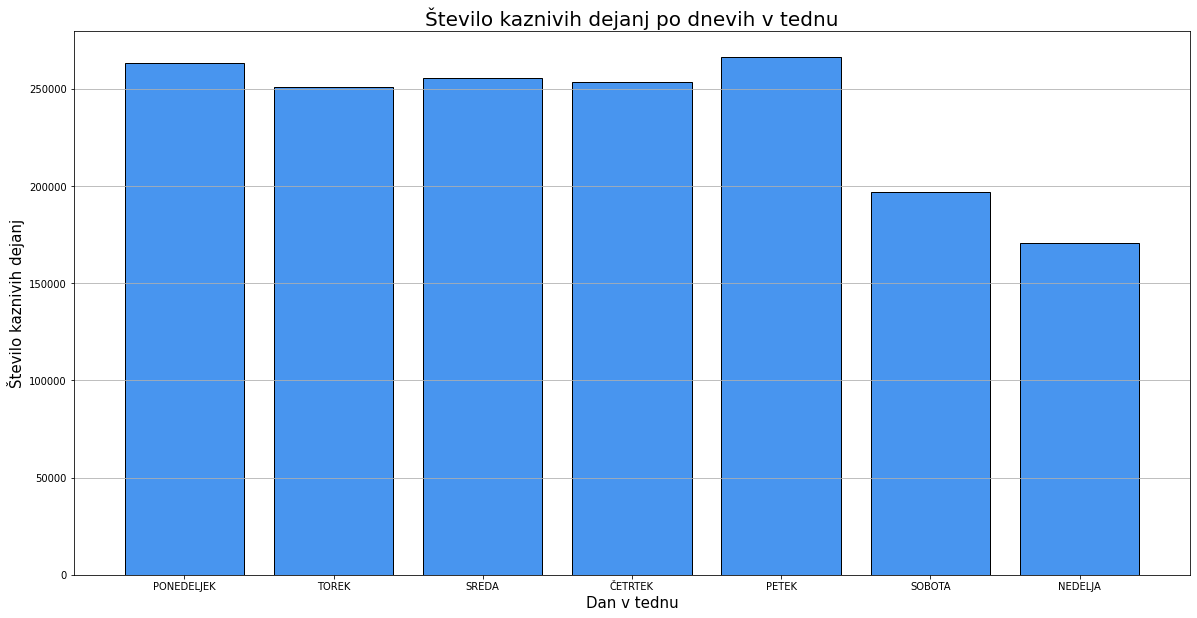

In [31]:
dnevi = all_years.DanVTednu.value_counts().sort_index()
x = ['PONEDELJEK', 'TOREK', 'SREDA', 'ČETRTEK', 'PETEK', 'SOBOTA', 'NEDELJA']
y = [dnevi.PONEDELJEK, dnevi.TOREK, dnevi.SREDA, dnevi.ČETRTEK, dnevi.PETEK, dnevi.SOBOTA, dnevi.NEDELJA]

plt.figure(figsize=(20,10))
plt.bar(x, y, color=color_pallete[9], edgecolor='black')
plt.title('Število kaznivih dejanj po dnevih v tednu', fontsize=20)
plt.xlabel('Dan v tednu', fontsize=15)
plt.ylabel('Število kaznivih dejanj', fontsize=15)
plt.grid(axis='y')
plt.show()

**Ugotovitve:**    
Iz grafa lahko vidimo, da je največ primerov kaznivih dejanj med tednom. Med vikendom pa je le teh največ v soboto, nekoliko manj pa v nedeljo.

**Število zaključenih primerov kaznivih dejanj po letih za leta 2009-2020**

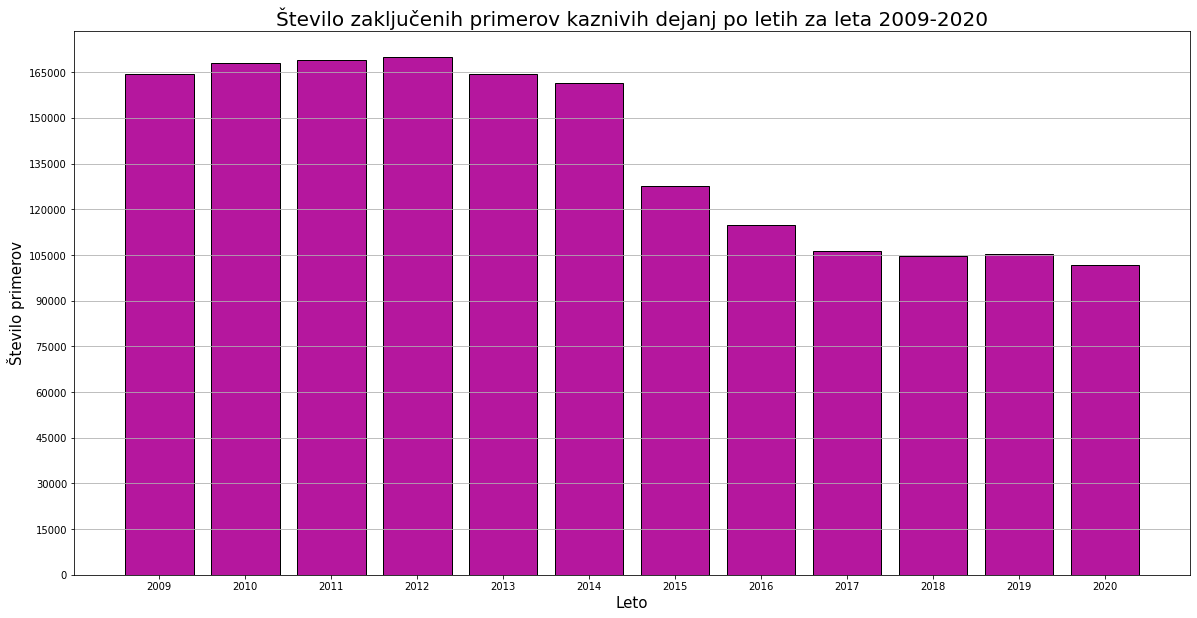

In [32]:
time_dataframes = {k:v for k,v in dataframes.items()}

l_df = copy(list(time_dataframes.values()))

po_letih = [len(df) for df in l_df]

plt.figure(figsize=(20,10))

# subplot 1. prikaz kriminalističih primerov po letih za leta 2009-2020
plt.bar(['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'], po_letih, color=color_pallete[2], edgecolor='black')
plt.yticks(np.arange(0, 180000, step=15000))
plt.grid(axis='y')
plt.title('Število zaključenih primerov kaznivih dejanj po letih za leta 2009-2020', fontsize=20)
plt.ylabel('Število primerov', fontsize=15)
plt.xlabel('Leto', fontsize=15)
plt.show()

**Ugotavljanje v katerih urah se zgodi največ kriminala**  
Pri tej analizi uporabimo podatke za vsa leta po stolpcu **UraStoritve** ter jih povprečimo da dobimo bolj splošne rezultate

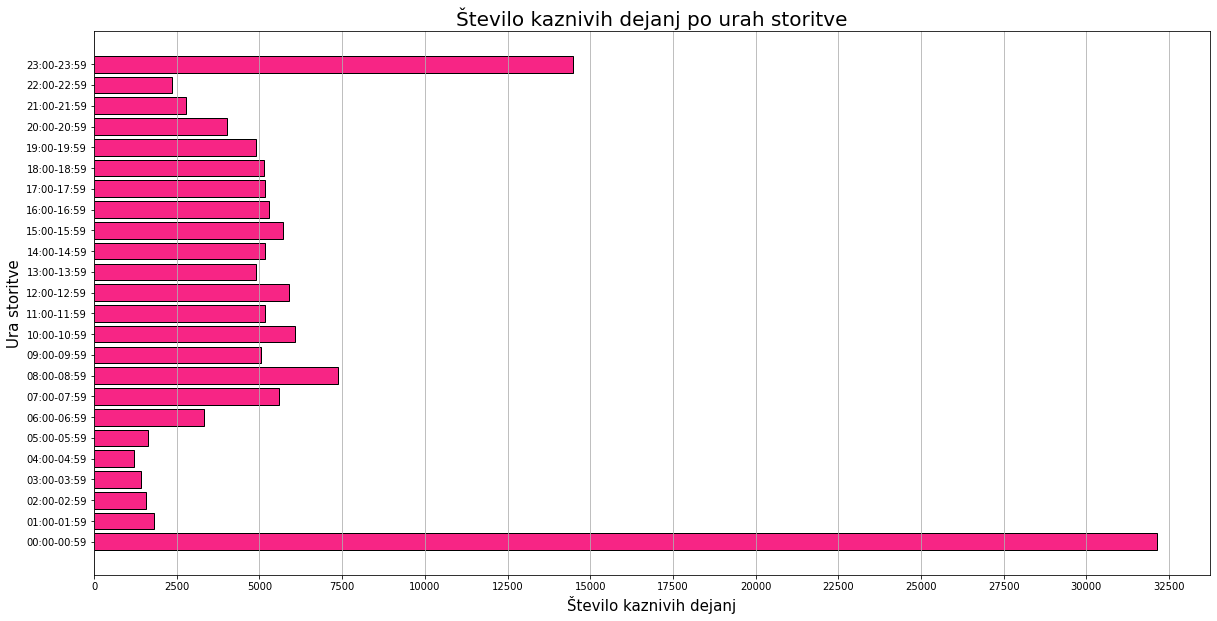

In [33]:
dataframes_fixed_dates = {}

for key, value in time_dataframes.items():
    df1 = copy(time_dataframes[key])
    df1['MesecStoritve'] = df1['MesecStoritve'].apply(lambda x: str(x)[:-4]+'.'+str(x)[-4:])
    df1['MesecStoritve'] =  pd.to_datetime(df1['MesecStoritve'], format='%m.%Y')
    dataframes_fixed_dates[key] = df1

ure_vse = []
povp_ure = []
ure = [
    '00:00-00:59',
    '01:00-01:59',
    '02:00-02:59',
    '03:00-03:59',
    '04:00-04:59',
    '05:00-05:59',
    '06:00-06:59',
    '07:00-07:59',
    '08:00-08:59',
    '09:00-09:59',
    '10:00-10:59',
    '11:00-11:59',
    '12:00-12:59',
    '13:00-13:59',
    '14:00-14:59',
    '15:00-15:59',
    '16:00-16:59',
    '17:00-17:59',
    '18:00-18:59',
    '19:00-19:59',
    '20:00-20:59',
    '21:00-21:59',
    '22:00-22:59',
    '23:00-23:59',
]

i = 0
for key, value in dataframes_fixed_dates.items():
    ure_vse.append(list(value['UraStoritve'].value_counts().sort_index()))
    i += 1

for i in range(len(ure_vse[1])):
    x = 0
    for ura in ure_vse:
        x += ura[i]
    povp_ure.append(x/len(ure_vse))

plt.figure(figsize=(20,10))
plt.barh(ure, povp_ure, color='#F72585', edgecolor='black')
plt.grid(axis='x')
plt.xticks(np.arange(0, 35000, step=2500))
plt.title('Število kaznivih dejanj po urah storitve', fontsize=20)
plt.ylabel('Ura storitve', fontsize=15)
plt.xlabel('Število kaznivih dejanj', fontsize=15)
plt.show()

**UGOTOVITVE:** Iz ugotovitev se največ kaznivih dejanj zgodi med **23:00 in 01:00**. V teh urah je največ ljudi prostih in je zato logično, da je v teh urah največ kaznivih dejanj. Dejavnik je tudi alkohol saj se ob takih urah odvija največ zabav in največ ljudi ob takih urah zahaja v lokale. Število kaznivih dejanj pade v urah spanca **01:00-06:00** ter **21:00-23:00**. Podnevi kazniva dejanja narastejo, ampak še vedno ne tako kot med 23:00 in 01:00.

**Povzročena škoda glede na leto, mesec, dan in časovno obdobje**    
V naslednjem poglavju smo raziskovali koliko škode je bilo povzročene glede na naslednje dejavnike:
1. Leto,
2. Mesec,
3. Dan,
4. Časovno obdobje    

Najprej smo se odločili, da stolpec 'Skoda' pretvorimo tako da sestejemo spodnjo in zgornjo mejo in delimo z 2 in tako dobimo povprečno škodo tistega primera(primere brez škode in brez zapisa smo nastavili na 0) ter jo zapišemo v nov stolpec 'PovprecnaSkoda', ki bo uporaben pri analizi glede na druge stolpce.

In [34]:
full_KD['PovprecnaSkoda'] = 'nan'

full_KD['Skoda'] = full_KD['Skoda'].replace(np.nan, 'BREZ')

#Sprememba podatka iz stolpca 'Skoda' v stolpec 'PovprecnaSkoda'
full_KD.loc[full_KD['Skoda'] == 'DO 100 EUR', 'PovprecnaSkoda'] = float(50)
full_KD.loc[full_KD['Skoda'] == '100 - 1.000 EUR', 'PovprecnaSkoda'] = float((100+1000)/2)
full_KD.loc[full_KD['Skoda'] == '1.000 - 10.000 EUR', 'PovprecnaSkoda'] = float((1000+10000)/2)
full_KD.loc[full_KD['Skoda'] == '10.000 - 100.000 EUR', 'PovprecnaSkoda'] = float((10000+100000)/2)
full_KD.loc[full_KD['Skoda'] == '100.000 - 500.000 EUR', 'PovprecnaSkoda'] = float((100000+5000000)/2)
full_KD.loc[full_KD['Skoda'] == 'NAD 500.000 EUR', 'PovprecnaSkoda'] = float(500000)
full_KD.loc[full_KD['Skoda'] == 'BREZ', 'PovprecnaSkoda'] = float(0)
full_KD.loc[full_KD['Skoda'] == np.nan, 'PovprecnaSkoda'] = float(0)

povprecna_skoda_ura = full_KD.groupby('UraStoritve')['PovprecnaSkoda'].mean().round(1)
povprecna_skoda_mesec = full_KD.groupby('MesecStoritve')['PovprecnaSkoda'].mean().round(1)
povprecna_skoda_dan = full_KD.groupby('DanVTednu')['PovprecnaSkoda'].mean().round(1)
povprecna_skoda_leto = full_KD.groupby('LetoStoritve')['PovprecnaSkoda'].mean().round(1)

**Povprečna škoda glede na leto**    


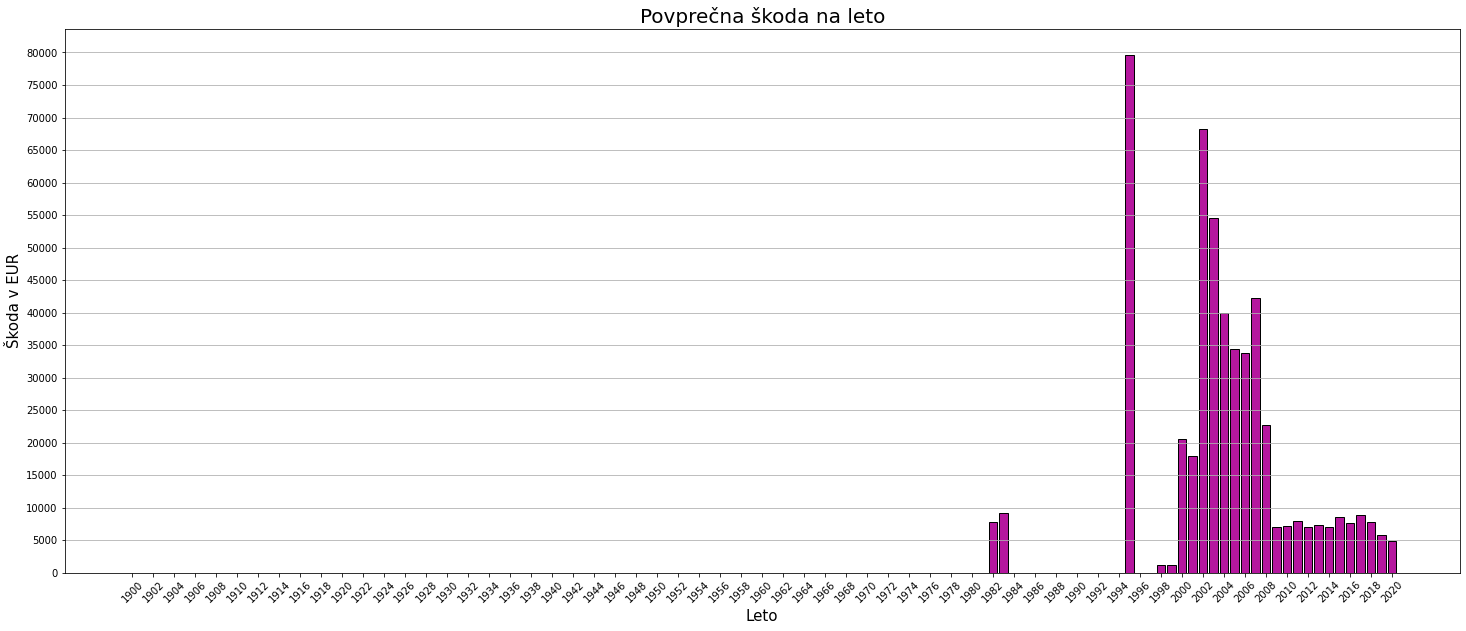

In [35]:
povprecna_skoda_leto = povprecna_skoda_leto.sort_index()
x = list(povprecna_skoda_leto.index)
y = list(povprecna_skoda_leto.values)

plt.figure(figsize=(25,10))
plt.bar(x,y, color=color_pallete[2], edgecolor='black')
plt.xticks(np.arange(x[0], x[-1]+2, step=2), rotation=45)
plt.yticks(np.arange(0, max(y)+5000, step=5000))
plt.grid(axis='y')
plt.title('Povprečna škoda na leto', fontsize=20)
plt.xlabel('Leto', fontsize=15)
plt.ylabel('Škoda v EUR', fontsize=15)
plt.show()

**Povprečna škoda glede na mesec**

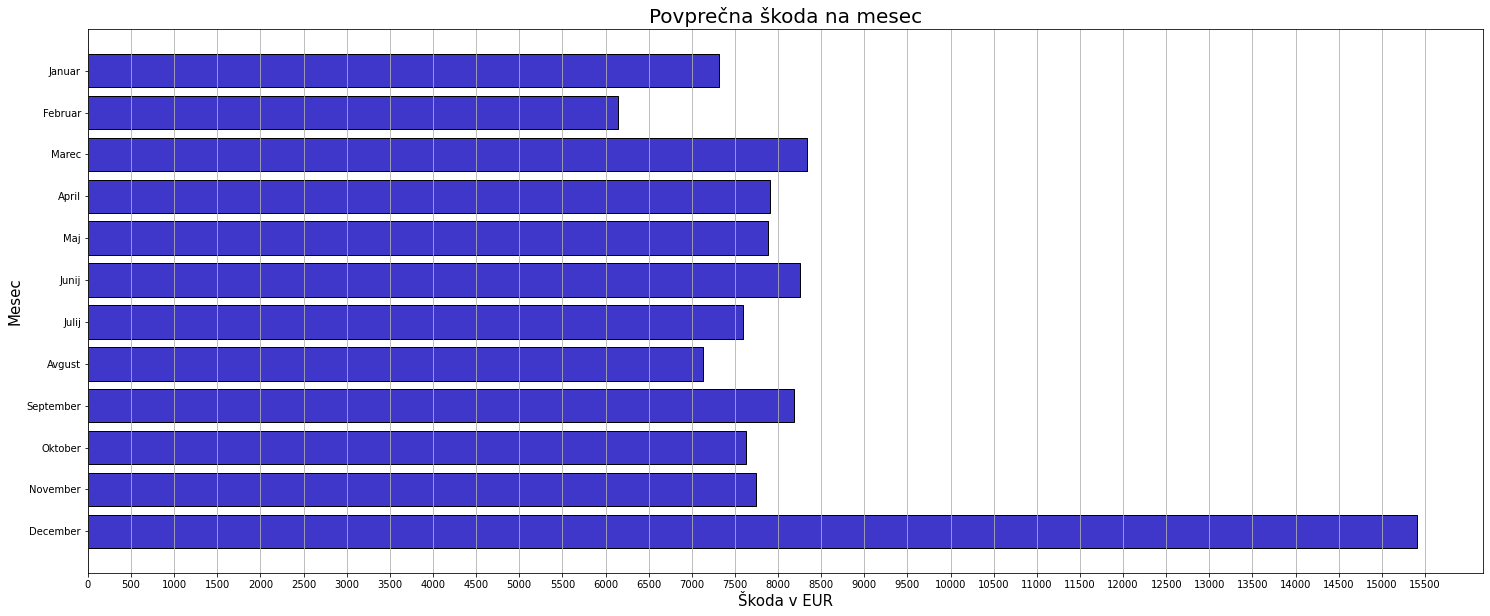

In [36]:
x = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']
y = [
    povprecna_skoda_mesec.Januar,
    povprecna_skoda_mesec.Februar,
    povprecna_skoda_mesec.Marec,
    povprecna_skoda_mesec.April,
    povprecna_skoda_mesec.Maj,
    povprecna_skoda_mesec.Junij,
    povprecna_skoda_mesec.Julij,
    povprecna_skoda_mesec.Avgust,
    povprecna_skoda_mesec.September,
    povprecna_skoda_mesec.Oktober,
    povprecna_skoda_mesec.November,
    povprecna_skoda_mesec.December
]

x.reverse()
y.reverse()

plt.figure(figsize=(25,10))
plt.barh(x, y, color=color_pallete[7], edgecolor='black')
plt.xticks(np.arange(0, y[0]+500, step=500))
plt.grid(axis='x')
plt.title('Povprečna škoda na mesec', fontsize=20)
plt.xlabel('Škoda v EUR', fontsize=15)
plt.ylabel('Mesec', fontsize=15)
plt.show()


**Ugotovitve:**    
Iz grafa je zelo dobro razvidno, da se največ škode povzroči v mesecu Decembru. Najverjetnje je to zaradi prazničnega časa(pirotehnika, zabave, dela prosti dnevi) ter zaradi sneženega vremena(več prometnih nesreč).

**Povprečna škoda glede na dan**

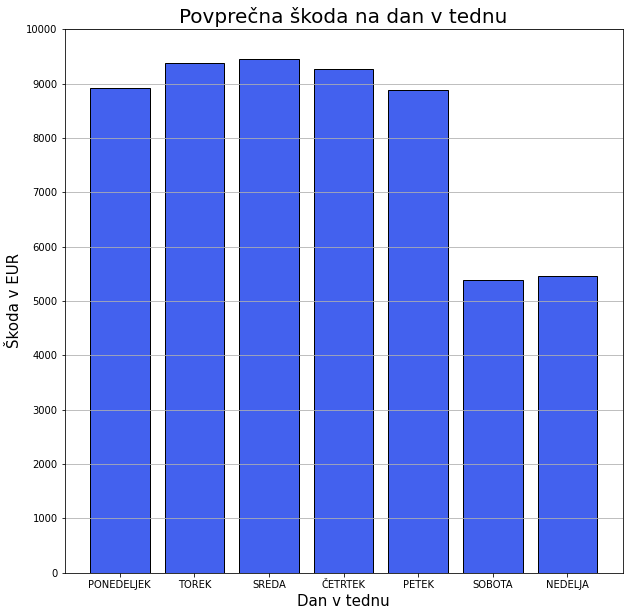

In [37]:
x = ['PONEDELJEK', 'TOREK', 'SREDA', 'ČETRTEK', 'PETEK', 'SOBOTA', 'NEDELJA']
y = [povprecna_skoda_dan.PONEDELJEK,
     povprecna_skoda_dan.TOREK,
     povprecna_skoda_dan.SREDA, 
     povprecna_skoda_dan.ČETRTEK, 
     povprecna_skoda_dan.PETEK, 
     povprecna_skoda_dan.SOBOTA, 
     povprecna_skoda_dan.NEDELJA
]

plt.figure(figsize=(10,10))
plt.bar(x, y, color=color_pallete[8], edgecolor='black')
plt.yticks(np.arange(0, max(y)+1000, step=1000))
plt.grid(axis='y')
plt.title('Povprečna škoda na dan v tednu', fontsize=20)
plt.xlabel('Dan v tednu', fontsize=15)
plt.ylabel('Škoda v EUR', fontsize=15)
plt.show()

**Ugotovitve:**    
Iz grafa lahko vidimo da je med tednom več povzročene škode kot pa med vikendom, kot smo videli tudi iz števila primerov po dnevih. Zanimivo pa je, da ima nedelja večjo povprečno škodo kot sobota, saj smo videli da je v soboto več primerov kot v nedeljo.

**Povprečna škoda glede na časovno območje**

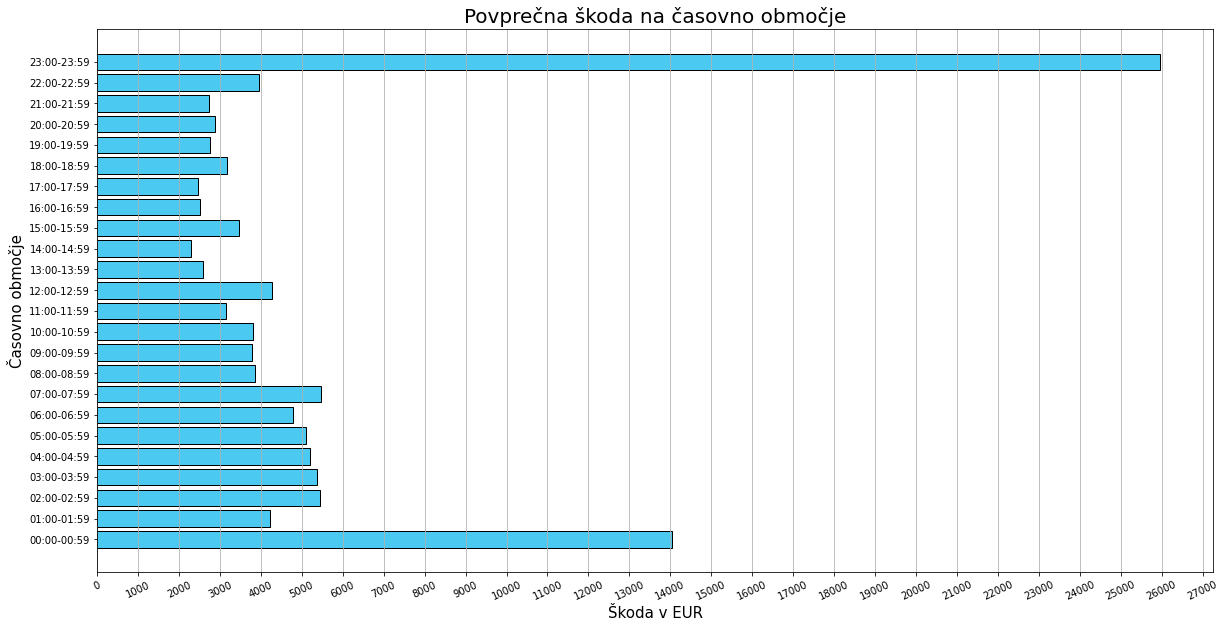

In [38]:
x = list(povprecna_skoda_ura.index)
y = list(povprecna_skoda_ura.values)

plt.figure(figsize=(20,10))
plt.barh(x, y, color=color_pallete[10], edgecolor='black')
plt.xticks(np.arange(0, max(y)+2000, step=1000), rotation=25)
plt.grid(axis='x')
plt.title('Povprečna škoda na časovno območje', fontsize=20)
plt.xlabel('Škoda v EUR', fontsize=15)
plt.ylabel('Časovno območje', fontsize=15)
plt.show()

**Ugotovitve:**    
Če primerjamo število primerov in škodo lahko vidimo da je bilo v časovnem obdobju 00:00-00:59 narejeno manj škode kot v obdobju 23:00-23:59, kjub temu da je bilo v obdobju 00:00-00:59 storjenih veliko več kaznivih dejanj.

## Priprava podatkov za prikaz kriminala glede na organizirano združbo

Grafa glede na vrednost organizirane zbružbe sta ločena (graf za DA, graf za NE), saj je le tako mogoč prikaz kriminala glede na ti dve vrednost.

In [39]:
celota = full_KD.groupby("PUStoritveKD", sort=False).OrganiziranaZdruzba.value_counts()
celota_popravljeno = celota.drop(['DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE', 'NI PODATKA'])

stevilo_DA = [celota_popravljeno[11], celota_popravljeno[13], celota_popravljeno[7], 0, 0, celota_popravljeno[9], celota_popravljeno[3]+celota_popravljeno[17]
            , 0, celota_popravljeno[5], celota_popravljeno[1], celota_popravljeno[15], 0]

stevilo_NE =  [celota_popravljeno[10], celota_popravljeno[12], celota_popravljeno[6], 0, 0, celota_popravljeno[8], celota_popravljeno[2]+celota_popravljeno[16]
            , 0, celota_popravljeno[4], celota_popravljeno[0], celota_popravljeno[14], 0]

**Prikaz grafa Slovenije za vrednost organizirana združba DA**

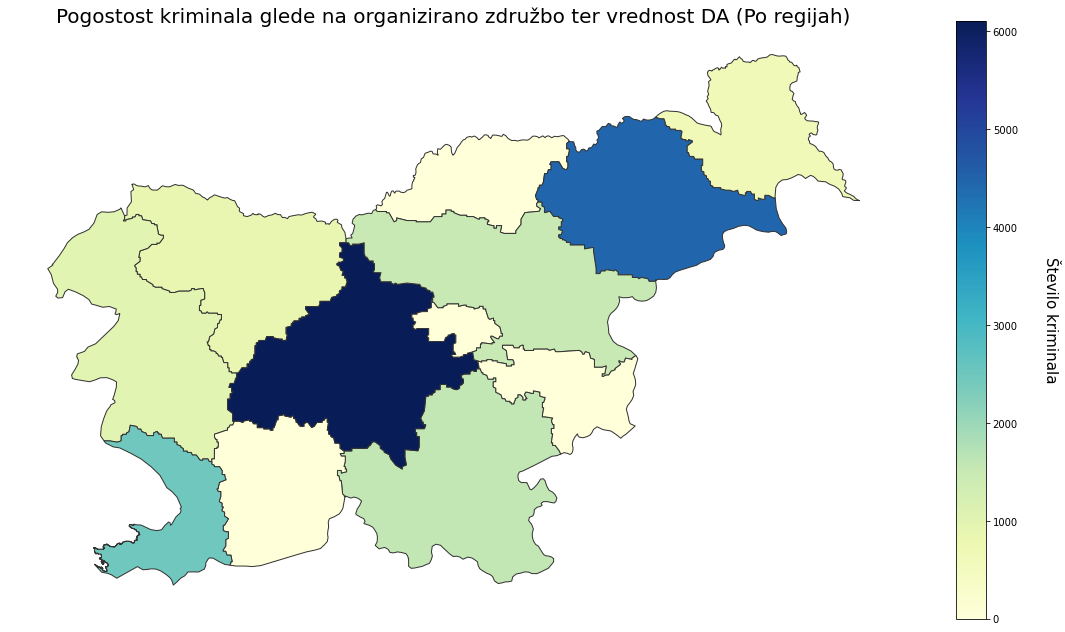

In [40]:
slovenia = gpd.read_file('slovenija_map/regije/reg.shp', encoding='cp1250')

slovenia['stevilo'] = stevilo_DA
fig, ax = plt.subplots(1, figsize=(20, 20))
plt.axis('off')
plt.title('Pogostost kriminala glede na organizirano združbo ter vrednost DA (Po regijah)', fontsize=20)
slovenia.plot(column='stevilo', cmap='YlGnBu', ax=ax, edgecolor='.2')
bar_info = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=max(stevilo_DA)))
bar_info._A = []
cbar = fig.colorbar(bar_info, shrink=0.55)
cbar.set_label('Število kriminala', fontsize=15, rotation=270, labelpad=40)

**Prikaz grafa Slovenije za vrednost organizirana združba NE**

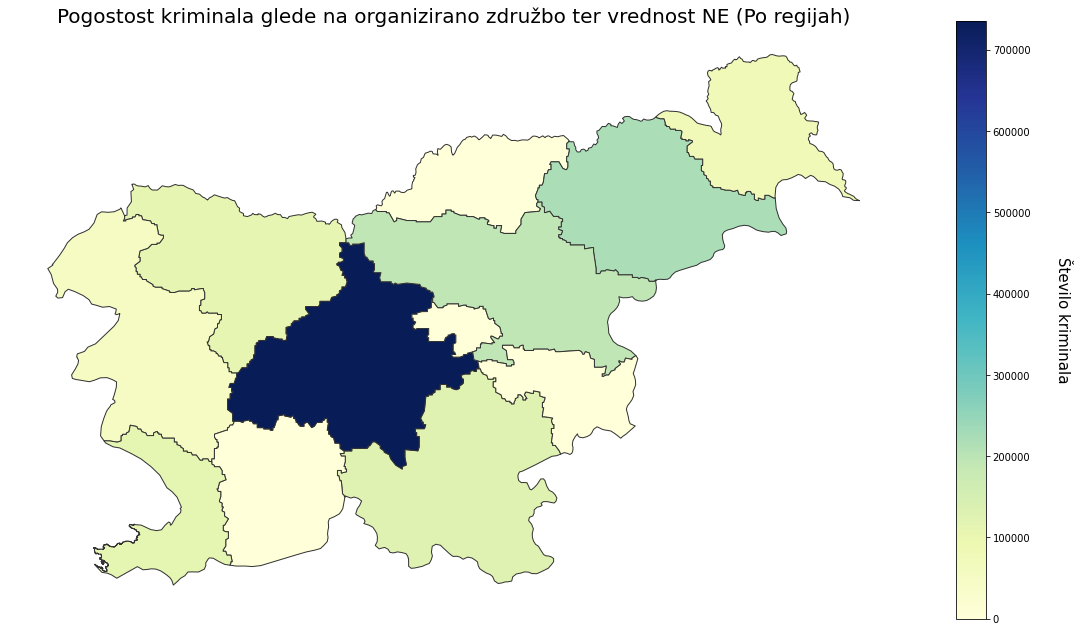

In [41]:
slovenia['stevilo'] = stevilo_NE
fig, ax = plt.subplots(1, figsize=(20, 20))
plt.axis('off')
plt.title('Pogostost kriminala glede na organizirano združbo ter vrednost NE (Po regijah)', fontsize=20)
slovenia.plot(column='stevilo', cmap='YlGnBu', ax=ax, edgecolor='.2')
bar_info = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=max(stevilo_NE)))
bar_info._A = []
cbar = fig.colorbar(bar_info, shrink=0.55)
cbar.set_label('Število kriminala', fontsize=15, rotation=270, labelpad=40)

**ODGOVOR:** <br>Kot lahko opazimo iz prvega grafa lahko vidimo, da je na največ kriminala v Sloveniji, ki poteka v neki organizirani združbi, v osrednjeslovenski regiji, najmanj pa v Pomurski regiji.
<br>Iz drugega grafa pa lahko opazimo, da je prav tako največ kriminala, ki ne poteka v organiziranih združbah, v osrednjeslovenski regiji, najmanj pa v Goriški in Pomurski regiji.

***OPOMNIK:*** Na grafu imamo vedno 4 regije, ki imajo vrednost 0, saj teh vrednosti za te regije, v naši tabeli, nismo imeli. <br>Regije za katere nismo imeli podatka v tabeli:
* Primorsko - notranjska regija,
* Zasavska regija,
* Posavska regija ter
* Koroška regija

**Prikaz kriminala po letnih glede na organizirane združbe (po letih skupaj in ločeno)**

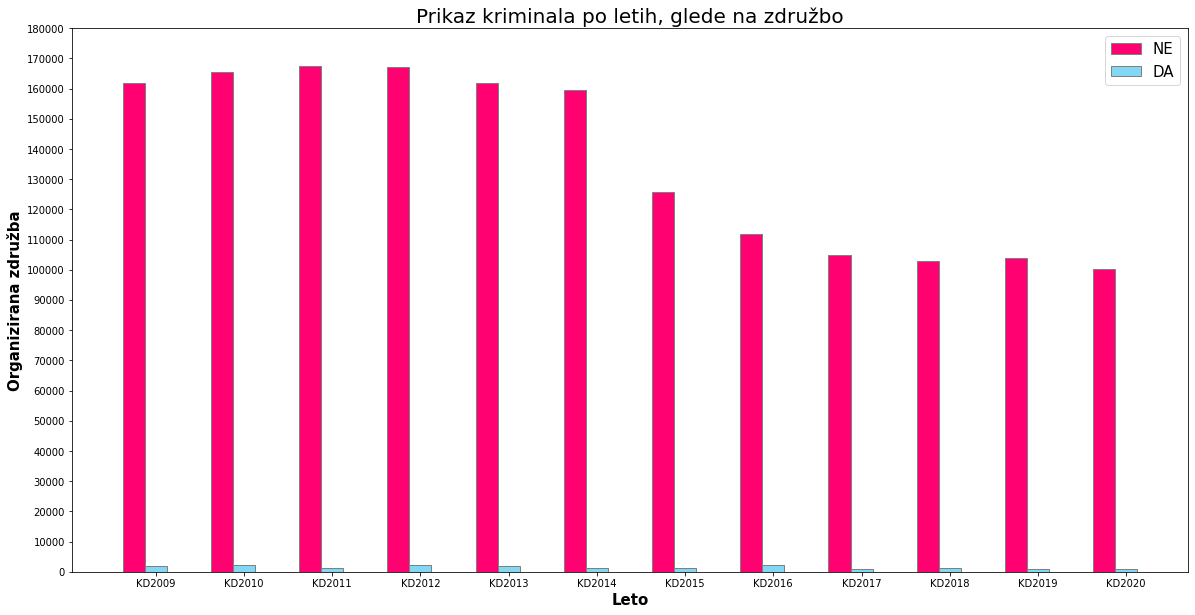

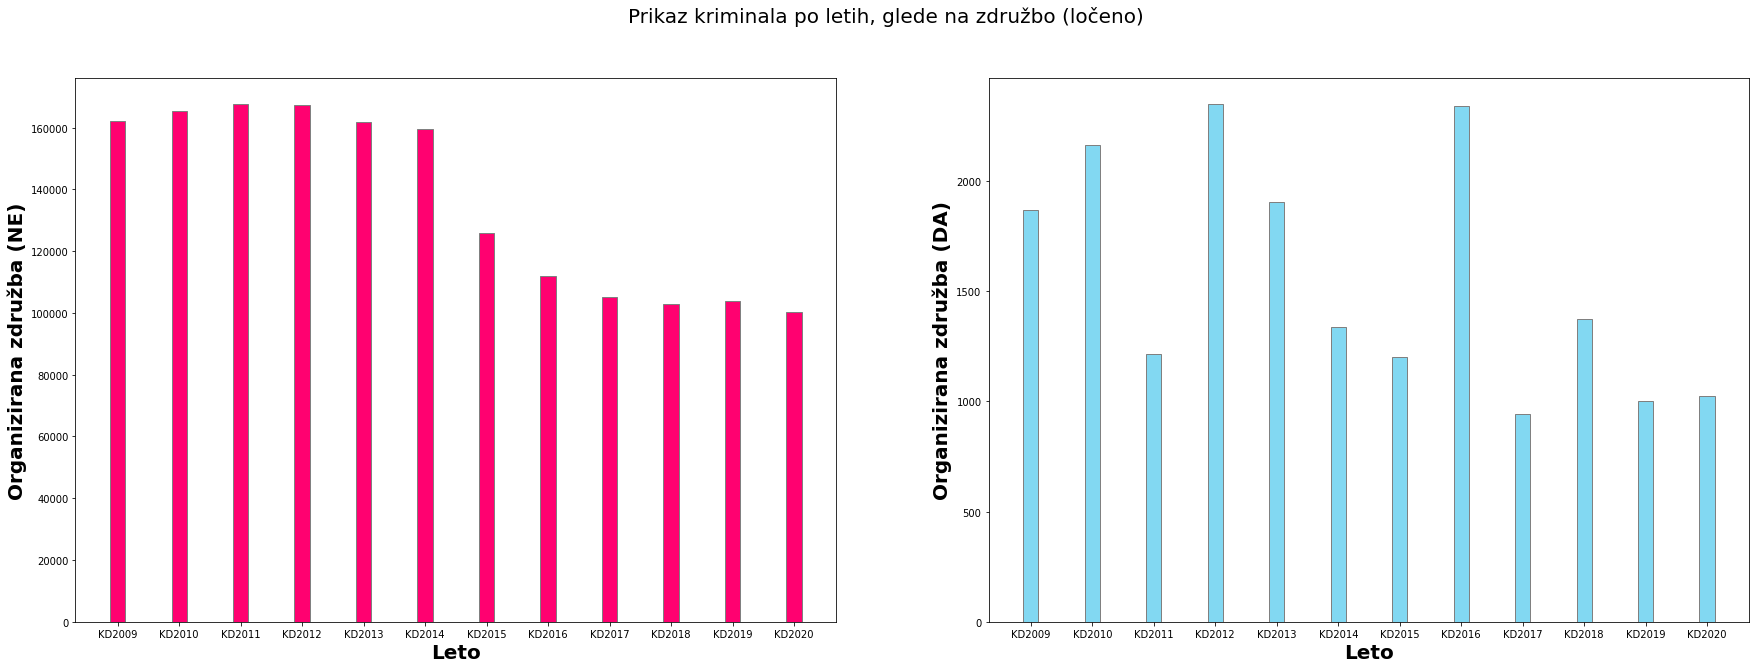

In [42]:
podatka = {}
podatki_NE = []
podatki_DA = []
ind = []

df = {k:v for k,v in dataframes.items()}

for key, value in df.items():
    df1 = copy(df[key])
    podatki = df1["OrganiziranaZdruzba"].value_counts()
    podatki_NE.append(podatki.values.tolist()[0])
    podatki_DA.append(podatki.values.tolist()[1])
    ind.append(key)

#Prikaz kriminala glede na združbo, lažje opažanje razlike
barWidth = 0.25
fig = plt.subplots(figsize =(20, 10))
br1 = np.arange(len(podatki_NE))
br2 = [x + barWidth for x in br1]

plt.title("Prikaz kriminala po letih, glede na združbo", fontsize=20)
plt.bar(br1, podatki_NE, color = '#FF0170', width = barWidth,
        edgecolor ='grey', label ='NE')
plt.bar(br2, podatki_DA, color ='#82D8F2', width = barWidth,
        edgecolor ='grey', label ='DA')
plt.xlabel('Leto', fontweight ='bold', fontsize = 15)
plt.ylabel('Organizirana združba', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(podatki_NE))], ind)
plt.yticks(np.arange(0,190000, step=10000))
plt.legend(fontsize=15)
plt.show()

#Prikaz kriminala glede na združbo ločeno, lažji prikaz števila
fg, (pl1, pl2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4,4]})
fg.set_size_inches(30,10)
fg.suptitle("Prikaz kriminala po letih, glede na združbo (ločeno)", fontsize=20)

pl1.bar(ind, podatki_NE ,color = '#FF0170', width = barWidth, edgecolor ='grey', label ='NE')
pl1.set_xlabel('Leto', fontweight ='bold', fontsize = 20)
pl1.set_ylabel('Organizirana združba (NE)', fontweight ='bold', fontsize = 20)

pl2.bar(ind, podatki_DA, color = '#82D8F2', width = barWidth, edgecolor ='grey', label ='DA')
pl2.set_xlabel('Leto', fontweight ='bold', fontsize = 20)
pl2.set_ylabel('Organizirana združba (DA)', fontweight ='bold', fontsize = 20)

plt.show()


**UGOTOVITVE:** Iz grafov je kar najbolje razvidno, da v Sloveniji v vseh teh letih ni prišlo do večjega števila kriminala v organiziranih združbah, kar pomeni, da so skoraj vsi kriminalci, posamezniki. Razlika je vidna predvsem v 1. grafu, ki prikazuje obe vrednosti skupaj. Nato sta pod njim še razčlenjeni verziji za lažjo berljivost številk.

V naslednjem grafu bomo prikazali udeležence združn in ne združb glede na njihovo starost (je mladoleten ali ne mladoletna). Iz celega seznama imamo naslednje starostne skupine:
* PRAVNA OSEBA
* 34-44
* 24-34  
* 44-54
* 54-64
* 18-24
* NAD 64
* 16-18
* 41821
* 14-16
* 00-07
* NI PODATKA
* NI POJAVA<br><br>
Iz seznama smo odstranili vrednosti o PRAVNIH OSEBAH, ker ta vrednost predstavlja gospodarske družbe, zavode, društva, organe in druge organizacije, vrednost 41821, saj ta podatek ne predstavlja natanče starosti in nato še vrednosti NI PODATKA ter NI POJAVA. Ostale vrednosti bomo grupirali po starosti in izrisali grafe glede na pripadnost organizirani združbi.

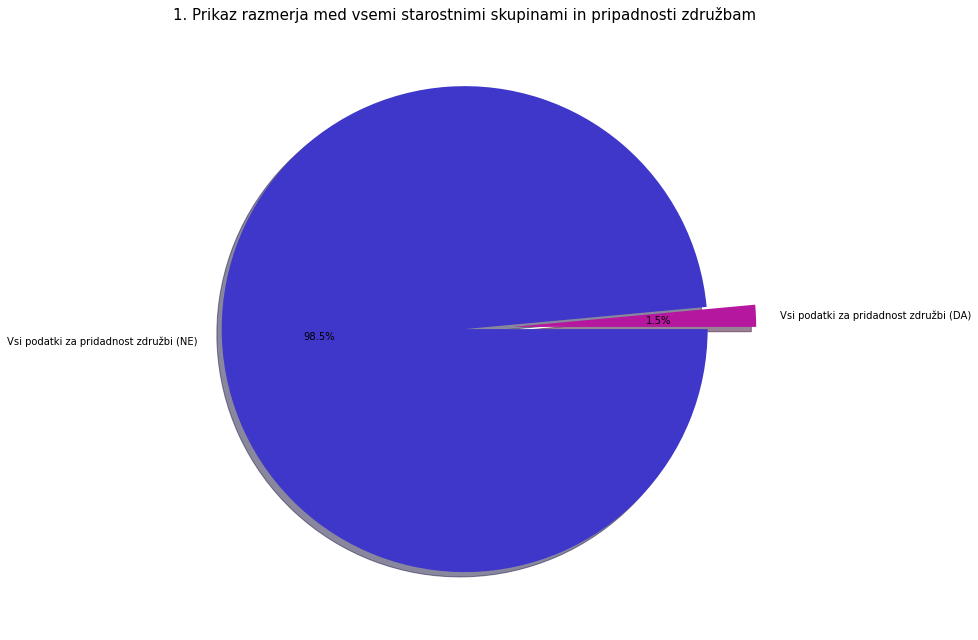

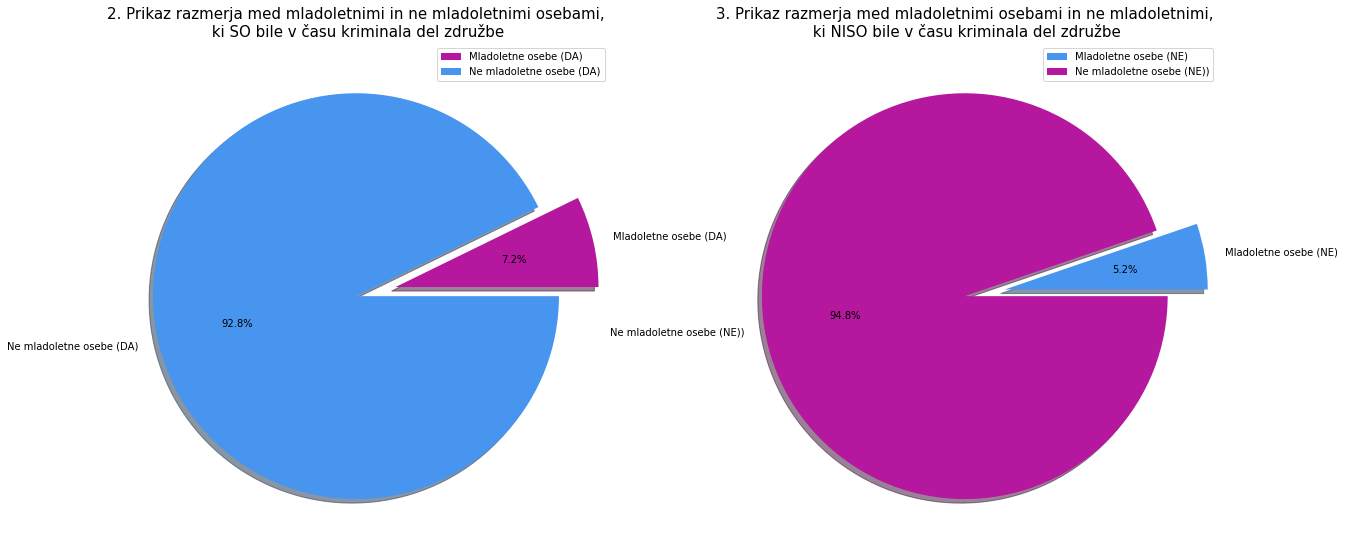

In [43]:
neki = full_KD.groupby("StarostniRazred", sort=False).OrganiziranaZdruzba.value_counts()

je_mladoleten = ((full_KD["StarostniRazred"] == "00-07") | (full_KD["StarostniRazred"] == "41821") | 
                    (full_KD["StarostniRazred"] == "14-16") | (full_KD["StarostniRazred"] == "16-18"))

neki.pop('NI PODATKA')
neki.pop('NI POJAVA')
neki.pop('PRAVNA OSEBA')
neki.pop('41821')

neki = neki.sort_index()
podatki_DA = []
podatki_NE = []

for i in neki.keys():
    if i[1] == 'DA':
        podatki_DA.append(neki[i])
    else:
        podatki_NE.append(neki[i])

mladoleten_DA = sum(podatki_DA[:3])
mladoleten_NE = sum(podatki_NE[:3])
ne_mladoleten_DA = sum(podatki_DA[3:])
ne_mladoleten_NE = sum(podatki_NE[3:])

pod_DA = sum(podatki_DA)
pod_NE = sum(podatki_NE)

list1 = np.array([mladoleten_DA, ne_mladoleten_DA])
list2 = np.array([mladoleten_NE, ne_mladoleten_NE])
list3 = np.array([pod_DA, pod_NE])


mylabels1 = ["Mladoletne osebe (DA)", "Ne mladoletne osebe (DA)"]
mylabels2 = ["Mladoletne osebe (NE)", "Ne mladoletne osebe (NE))"]
mylabels3 = ["Vsi podatki za pridadnost združbi (DA)", "Vsi podatki za pridadnost združbi (NE)"]
myexplode = [0.2, 0]

plt.figure(figsize=(14,9), tight_layout = True)
plt.title("1. Prikaz razmerja med vsemi starostnimi skupinami in pripadnosti združbam", fontsize= 15)
plt.pie(list3, labels = mylabels3, explode = myexplode, shadow = True, autopct='%1.1f%%', colors=[color_pallete[2], color_pallete[7]])

fig, (pl1, pl2) = plt.subplots(1,2, figsize =(20, 15))

pl1.title.set_text("2. Prikaz razmerja med mladoletnimi in ne mladoletnimi osebami,\n ki SO bile v času kriminala del združbe")
pl1.title.set_fontsize(15)
pl1.pie(list1, labels = mylabels1, explode = myexplode, shadow = True, autopct='%1.1f%%',colors=[color_pallete[2], color_pallete[9]])
pl1.legend(loc='upper right')

pl2.title.set_text("3. Prikaz razmerja med mladoletnimi osebami in ne mladoletnimi,\n ki NISO bile v času kriminala del združbe")
pl2.title.set_fontsize(15)
pl2.pie(list2, labels = mylabels2, explode = myexplode, shadow = True, autopct='%1.1f%%', colors=[color_pallete[9], color_pallete[2]])
pl2.legend(loc='upper right')

plt.show() 

**ODGOVOR:**<br>
***1. GRAF:*** Na tem grafu sta prikazana razmerja med osebami vseh starosti in pripadnosti organiziranim združbam. Kot lahko opazimo je med vrednostima DA in NE zelo opazna razlika. To pomeni, da je skozi leta v Sloveniji bilo zelo malo kriminala, ki je vseboval neko organizirano združbo.<br>
***2. GRAF:*** Iz drugega grafa lahko vidimo, da je razmerje med mladoletnimi in ne mladoletnimi osebami, ki so bile vpletene v organizirano združbo, kar veliko, kar nam pove, da so osebe mlajše od 18 let, manj vpletene v organiziran kriminal. <br>
***3. GRAF:*** Iz tretjega grafa lahko razberemo podobno kot iz prvega, razlika je samo v tem, da pri tem grafu prikazujemo mladoletne in ne mladoletne osebe, ki niso bile del organiziranega kriminala.<br>